# Coffea and Awkward

**March 15, 2023 at Beijing**

In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
import correctionlib, rich
import matplotlib.pyplot as plt
import sys
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

In [2]:
def load_event_dict(file_prefix, keys):
    data_subkeys = ['photon_pt','photon_eta','ele1_pt','ele2_pt','ele1_eta','ele2_eta','ele_mass','gee_mass','npvsGood','Rho_Calo','Rho_tracker','photon_r9','photon_seedGain','run']#'dr_lg',
    # data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'mu_mass','gmumu_mass','photon_endcap','photon_barrel','npvsGood','Rho_Calo','Rho_tracker','photon_r9','photon_seedGain','run']
    other_subkeys = data_subkeys + ['generator_weight', 'event_weight','LHEPdfWeight','LHEScaleWeight']#
    
    event_dict = {}
    for key in keys:
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        event_dict[key] = {}
        for subkey in subkeys:
            event_dict[key][subkey] = ak.from_parquet(f'{file_prefix}_{key}_{subkey}.parquet')
    return event_dict

In [3]:
keys = ['zg0_22','zg1_22', 'zg2_22','zg3_22','tt_22']  
# 读取数据
event_final = load_event_dict('../../selection_ele_file/v2/A/event_ele_final', keys)
# event_final = load_event_dict('../../selection_muon_file/v2/A/event_muon_final', keys)

In [4]:
event_final

{'zg0_22': {'photon_pt': <Array [37.3, 41.1, 30.6, ... 35.1, 31.8, 41.6] type='23579 * ?float32'>,
  'photon_eta': <Array [-0.681, -0.613, ... -1.14, 0.876] type='23579 * ?float32'>,
  'ele1_pt': <Array [32.7, 53.6, 57.2, ... 94.2, 42.7, 59.2] type='23579 * ?float32'>,
  'ele2_pt': <Array [26.6, 38.1, 33.6, 21.4, ... 22, 30, 35] type='23579 * ?float32'>,
  'ele1_eta': <Array [-2.05, -0.0661, 1.13, ... 1.84, 1.8] type='23579 * ?float32'>,
  'ele2_eta': <Array [0.104, 0.542, 1.39, ... 0.431, 0.97] type='23579 * ?float32'>,
  'ele_mass': <Array [85.6, 85.6, 88.4, ... 90.3, 89.2, 92.6] type='23579 * ?float32'>,
  'gee_mass': <Array [[116], [146], ... [202], [123]] type='23579 * option[var * ?float32]'>,
  'npvsGood': <Array [21, 39, 37, 44, 31, ... 25, 33, 18, 35] type='23579 * ?uint8'>,
  'Rho_Calo': <Array [8.54, 13.3, 11.4, ... 13.1, 8.97, 16.3] type='23579 * ?float32'>,
  'Rho_tracker': <Array [10.9, 19.3, 22.1, ... 17.7, 14.4, 21.9] type='23579 * ?float32'>,
  'photon_r9': <Array [1.0

# Pileup

In [5]:
# Read parquet file to pandas dataframe
file_path = os.path.join("../../pileup_reweighting/pileup_file", "data.parquet")
table = pq.read_table(file_path)
df = table.to_pandas()

# Convert back to your dictionary form
data_mc_ratios = {
    key: ak.from_iter(df[key].dropna().tolist())
    for key in df.columns
}

In [6]:
# 获取每个事件的综合pile-up权重
def get_weights(event_final, sample, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
        if variable == 'npvsGood':
            array_key = 'npvsGood'
        elif variable == 'GridRhoFastjetCentralChargedPileUp':
            array_key = 'Rho_tracker'
        else:
            array_key = 'Rho_Calo'

        bin_indices = np.digitize(event_final[sample][array_key], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
        mean_weight = np.mean(np.array(pu_weights), axis=0)
        
        # 限制权重在0.2到3的范围内
        mean_weight = np.clip(mean_weight, 0.2, 3.0)
    return mean_weight

# 计算所有样本的pile-up权重
samples = keys
all_pileup_weights = {}

for sample in samples:
    all_pileup_weights[sample] = get_weights(event_final, sample, data_mc_ratios)

# 打印权重
for sample, weights in all_pileup_weights.items():
    print(f"{sample}: {weights}")
    print(f"average {sample}:{np.average(weights)}" )


zg0_22: [0.28189166 1.01717276 0.80811083 ... 0.83218788 0.26923338 1.24401673]
average zg0_22:0.7427095501549392
zg1_22: [0.33999209 0.72697934 0.33999209 ... 0.78146394 0.56982593 0.84721426]
average zg1_22:0.7543307314807968
zg2_22: [1.65357942 0.56611724 1.61566721 ... 0.80149275 0.64838478 0.56611724]
average zg2_22:0.7740556697299404
zg3_22: [0.25134242 0.87804756 0.58564628 ... 0.41159184 0.70440741 1.07403628]
average zg3_22:0.7957896994396053
tt_22: [0.42506149 0.96557628 2.14513271 0.33999209 2.09629967 0.83218788
 0.70746006 1.48095315 1.81788849 0.90548919 0.67695195 2.05565192
 0.37414429 0.28189166 0.2        0.73143475 1.23064235 1.05116555
 0.30073151 0.68111967 1.72929259 0.67695195 0.56465321 1.4373734
 1.83450803 0.65868591 1.09493763 2.23770479 0.41159184 0.49731656
 0.26923338 0.20325888 0.65025477 0.63123045 0.53071558 0.37594551
 0.49731656 0.39245329 0.29976319 0.84721426 2.89397446 0.88102093
 0.8938725  0.50107526 0.56465321 1.38268896 0.76553957 0.62969519
 0

## MuonSFs

In [8]:
muon_id_correction = correctionlib.CorrectionSet.from_file('../../official_SFs/ScaleFactors_Muon_Z_ID_ISO_2022_schemaV2.json')['NUM_TightPFIso_DEN_TightID']

In [9]:
# read the parquet file back to a DataFrame
df_read = pd.read_parquet("../../muon_trigger_sfs/trigger_file/SF_2D.parquet")

# convert the DataFrame back to a numpy array
SF_2D = df_read.to_numpy()
# df = pd.DataFrame(SF_2D, columns=["pt", "SF", "SF_error"])
# # Convert the DataFrame to an Awkward Array
# SF_2D = ak.Array(df.to_dict("list"))
SF_2D

array([[3.00000000e+01, 9.91839378e-01, 5.09682502e-02],
       [4.84615385e+01, 9.64846215e-01, 2.76343671e-02],
       [6.69230769e+01, 9.48994504e-01, 1.54559530e-02],
       [8.53846154e+01, 9.52363231e-01, 1.10242545e-02],
       [1.03846154e+02, 9.47176894e-01, 1.03649392e-02],
       [1.22307692e+02, 9.40863486e-01, 1.09711319e-02],
       [1.40769231e+02, 9.32824432e-01, 1.29997259e-02],
       [1.59230769e+02, 9.39524226e-01, 1.52510700e-02],
       [1.77692308e+02, 9.54437999e-01, 1.60371282e-02],
       [1.96153846e+02, 9.72696587e-01, 1.92487797e-02],
       [2.14615385e+02, 9.69485565e-01, 2.37184520e-02],
       [2.33076923e+02, 8.86626061e-01, 3.56691567e-02],
       [2.51538462e+02, 9.07257547e-01, 3.94513602e-02]])

In [9]:
# 定义需要提取muon1_pt值的键
trigger_weights = {}

for key in keys:
    # 获取muon1_pt值
    muon1_pt = event_final[key]['muon1_pt']

    # 限制muon1_pt的最大值
    muon1_pt = ak.where(muon1_pt > 290, 290, muon1_pt)

    # 计算bin索引
    bin_indices = np.digitize(muon1_pt, SF_2D[:, 0]) - 1
    
    # 对bin索引进行边界检查，防止索引超出SF_2D数组范围
    bin_indices = ak.where(bin_indices<0, 0, bin_indices)
    bin_indices = ak.where(bin_indices>=len(SF_2D), len(SF_2D)-1, bin_indices)

    # 使用bin索引从SF_2D中获取SF值
    trigger_weights[key] = SF_2D[bin_indices, 1]

#print(trigger_weights)


In [10]:
trigger_weights

{'zg0': array([0.95543025, 0.97366829, 0.88705839, ..., 0.95902037, 0.97366829,
        0.95543025]),
 'zg1': array([0.95549669, 0.95543025, 0.95387282, ..., 0.95543025, 0.93893202,
        0.95902037]),
 'zg2': array([0.89513351, 0.95902037, 0.92020574, ..., 0.95902037, 0.93711226,
        0.92020574]),
 'zg3': array([0.92020574, 0.92092092, 0.95628796, ..., 0.89513351, 0.89513351,
        0.93689788]),
 'tt': array([0.95543025, 0.94382656, 0.96998269, ..., 0.95543025, 0.97366829,
        0.95543025])}

## Electron SFs

In [7]:
ele_id_correction = correctionlib.CorrectionSet.from_file('../../official_SFs/electron_BCD.json')['Electron-ID-SF']

## Photon SFs

In [8]:
photon_id_correction = correctionlib.CorrectionSet.from_file('../../official_SFs/photon_BCD.json')['Photon-ID-SF']

# plot weight

In [9]:
photon_correction = correctionlib.CorrectionSet.from_file("../../official_SFs/photonSS_BCD.json")
# print(list(photon_correction.keys()))
photon_smearing_correction = photon_correction["2022Re-recoBCD_SmearingJSON"]
photon_scale_correction = photon_correction["2022Re-recoBCD_ScaleJSON"]

In [10]:
#BKG = {'zg1', 'zg2','zg3'}
BKG = {'zg0_22','zg1_22', 'zg2_22','zg3_22','tt_22', 'zz_22', 'wz_22', 'ww_22','nonpromptBCD_barrel','nonpromptBCD_endcap',} #nonpromptCD 'dy_22'
#BKG = {'tt', 'zz', 'wz', 'ww','nonprompt'}
#SIG = {'zg'}
# LUMI unit is fb
LUMI = {"2022FG": 21.6,"2022EFG": 39.22,"2022EG": 9.0,"2022CD":7.87}
XSEC = {
    # unit is pb^-1
#    'zg': 62.3,#run2 55.48
    'zg0_22': 124.6,
    'zg1_22': 1.74,#27.11
    'zg2_22': 0.30,#0.88,
    'zg3_22': 0.042,#0.073,
    'tt_22': 96.9,#101.78,
    'ww_22': 116.8,#80.27,
    'wz_22': 54.3,#29.14,
    'zz_22': 16.7,#12.83,
    'dy_22': 6346.0,
}

In [11]:
weight = {
    i: (
        (photon_scale_correction.evaluate("total_correction", np.array(event_final['data']['photon_seedGain']), np.array(event_final['data']['run']), np.array(event_final['data']['photon_eta'][:,0]),np.array(event_final['data']['photon_r9']),np.array(event_final['data']['photon_pt'][:,0]))) if i == 'data' else
        # #muon
        # 14/306 if i == 'nonpromptBCD_endcap' else 
        # 361/1732 if i == 'nonpromptBCD_barrel' else
        # ele
        80/186 if i == 'nonpromptBCD_endcap' else 
        502/1234 if i == 'nonpromptBCD_barrel' else        
        (
            np.sign(event_final[i]['generator_weight']) * XSEC[i] * LUMI['2022CD'] * 1e3 / 
            ak.sum(np.sign(event_final[i]['event_weight']))
        )
    ) for i in event_final #if 'data' not in i
}
weight


{'zg0_22': <Array [0.0526, 0.0526, ... 0.0526, -0.0526] type='23579 * ?float32'>,
 'zg1_22': <Array [0.0016, 0.0016, ... 0.0016, 0.0016] type='348818 * ?float32'>,
 'zg2_22': <Array [0.0205, 0.0205, ... 0.0205, 0.0205] type='7764 * ?float32'>,
 'zg3_22': <Array [0.00306, 0.00306, ... 0.00306, 0.00306] type='11191 * ?float32'>,
 'tt_22': <Array [0.0323, 0.0323, ... 0.0323, 0.0323] type='578 * ?float32'>}

In [12]:
for key in event_final:
    if key != 'data' and 'nonprompt' not in key:
# Photon_id
        photon_id_SFs = photon_id_correction.evaluate('2022Re-recoBCD','sf','Tight',np.array(event_final[key]['photon_eta']),np.array(event_final[key]['photon_pt']))
# Photon_smearing
        rho = photon_smearing_correction.evaluate("rho", np.array(event_final[key]['photon_eta']), np.array(event_final[key]['photon_r9']))  # rho is internal scale and smearing lingo
        rng = np.random.default_rng(seed=125)
        photon_smearing_SFs = rng.normal(loc=1., scale=rho)
#muon id&iso
        # muon1_pt_1 = ak.where(event_final[key]['muon1_pt'] > 200, 199.9, event_final[key]['muon1_pt'])
        # muon2_pt_1 = ak.where(event_final[key]['muon2_pt'] > 200, 199.9, event_final[key]['muon2_pt'])
        # muon1_pt_np = ak.to_numpy(muon1_pt_1)
        # muon2_pt_np = ak.to_numpy(muon2_pt_1)
        # muon1_eta_np = ak.to_numpy(abs(event_final[key]['muon1_eta']))
        # muon2_eta_np = ak.to_numpy(abs(event_final[key]['muon2_eta']))
        # Muon1_idiso_weights = muon_id_correction.evaluate(muon1_eta_np, muon1_pt_np, 'nominal')
        # Muon2_idiso_weights = muon_id_correction.evaluate(muon2_eta_np, muon2_pt_np, 'nominal')
        # Muontol_idiso_weights = Muon1_idiso_weights + Muon2_idiso_weights - Muon1_idiso_weights*Muon2_idiso_weights
#electron id
        ele1_idiso_weights = ele_id_correction.evaluate("2022Re-recoBCD","sf","Medium",np.array(event_final[key]['ele1_eta']),np.array(event_final[key]['ele1_pt']))
        ele2_idiso_weights = ele_id_correction.evaluate("2022Re-recoBCD","sf","Medium",np.array(event_final[key]['ele2_eta']),np.array(event_final[key]['ele2_pt']))
        eletol_idiso_weights = ele1_idiso_weights + ele2_idiso_weights - ele1_idiso_weights*ele2_idiso_weights
#all
        weight[key] = weight[key] * all_pileup_weights[key] * photon_id_SFs * photon_smearing_SFs * eletol_idiso_weights
        # weight[key] = weight[key] * all_pileup_weights[key] * photon_id_SFs * photon_smearing_SFs * muon_trigger_Sfs[key]  * Muontol_idiso_weights 

        # muonSFs_weights[key]
        # ak.flatten(photonSFs_weights) #


weight


{'zg0_22': <Array [0.0141, 0.0508, ... 0.014, -0.0636] type='23579 * ?float64'>,
 'zg1_22': <Array [0.000546, 0.00107, ... 0.00134] type='348818 * ?float64'>,
 'zg2_22': <Array [0.0328, 0.0112, ... 0.0138, 0.0116] type='7764 * ?float64'>,
 'zg3_22': <Array [0.000744, 0.00257, ... 0.00327] type='11191 * ?float64'>,
 'tt_22': <Array [0.0127, 0.0288, ... 0.0697, 0.00617] type='578 * ?float64'>}

In [13]:
ele1_id_up = {}
ele2_id_up = {}
ele1_id_down = {}
ele2_id_down = {}
for key in event_final:
    if key != 'data' and 'nonprompt' not in key:
        ele1_id_up[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfup","Medium",np.array(event_final[key]['ele1_eta']),np.array(event_final[key]['ele1_pt']))
        ele2_id_up[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfup","Medium",np.array(event_final[key]['ele2_eta']),np.array(event_final[key]['ele2_pt']))
        ele1_id_down[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfdown","Medium",np.array(event_final[key]['ele1_eta']),np.array(event_final[key]['ele1_pt']))
        ele2_id_down[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfdown","Medium",np.array(event_final[key]['ele2_eta']),np.array(event_final[key]['ele2_pt']))

ele1_id_down


{'zg0_22': array([0.97275659, 0.96631575, 0.9572572 , ..., 0.96631575, 0.97308784,
        0.95900842]),
 'zg1_22': array([0.96631575, 0.96631575, 0.97113447, ..., 0.95757485, 0.96217139,
        0.95900842]),
 'zg2_22': array([0.96631575, 0.94821428, 0.95757485, ..., 0.98396243, 0.98396243,
        0.9572572 ]),
 'zg3_22': array([0.97990755, 0.97526319, 0.94781343, ..., 0.95860993, 0.96631575,
        0.94821428]),
 'tt_22': array([0.95757485, 0.96631575, 0.95757485, 0.96217139, 0.96217139,
        0.95876546, 0.95860993, 0.96217139, 0.96540138, 0.95900842,
        0.96631575, 0.97308784, 0.97275659, 0.96188624, 0.96540138,
        0.96631575, 0.95757485, 0.96188624, 0.96631575, 0.96631575,
        0.96540138, 0.95256669, 0.94781343, 0.96631575, 0.97308784,
        0.95900842, 0.96188624, 0.96217139, 0.96217139, 0.94821428,
        0.96188624, 0.96217139, 0.9572572 , 0.96631575, 0.96631575,
        0.96217139, 0.96217139, 0.96631575, 0.98396243, 0.96631575,
        0.9572572 , 0.96540

In [14]:
import awkward as ak
import numpy as np

def calculate_muonidiso_uncertainty(central_weight, ele1_id_up, ele2_id_up,ele1_id_down,ele2_id_down):
    # 计算系统不确定性对应的上升和下降weights
    weight_ele1_up = central_weight * ele1_id_up
    weight_ele1_down = central_weight * ele1_id_down
    
    # 计算统计不确定性对应的上升和下降weights
    weight_ele2_up = central_weight * ele2_id_up
    weight_ele2_down = central_weight * ele2_id_down
    
    return weight_ele1_up, weight_ele1_down, weight_ele2_up, weight_ele2_down

samples = keys
for sample in samples:
    ele1_up_key = sample + "_ele1_id_up"
    ele1_down_key = sample + "_ele1_id_down"
    ele2_up_key = sample + "_ele2_id_up"
    ele2_down_key = sample + "_ele2_id_down"
    
    # 从字典中获取对应的不确定性
    ele1_id_up[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfup","Medium",np.array(event_final[key]['ele1_eta']),np.array(event_final[key]['ele1_pt']))
    ele2_id_up[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfup","Medium",np.array(event_final[key]['ele2_eta']),np.array(event_final[key]['ele2_pt']))
    ele1_id_down[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfdown","Medium",np.array(event_final[key]['ele1_eta']),np.array(event_final[key]['ele1_pt']))
    ele2_id_down[key] = ele_id_correction.evaluate("2022Re-recoBCD","sfdown","Medium",np.array(event_final[key]['ele2_eta']),np.array(event_final[key]['ele2_pt']))
    
    weight_ele1_up, weight_ele1_down, weight_ele2_up, weight_ele2_down = calculate_muonidiso_uncertainty(weight[sample], ele1_id_up[sample], ele2_id_up[sample],ele1_id_down[sample],ele2_id_down[sample])
    
    weight[ele1_up_key] = weight_ele1_up
    weight[ele1_down_key] = weight_ele1_down
    weight[ele2_up_key] = weight_ele2_up
    weight[ele2_down_key] = weight_ele2_down

weight


{'zg0_22': <Array [0.0141, 0.0508, ... 0.014, -0.0636] type='23579 * ?float64'>,
 'zg1_22': <Array [0.000546, 0.00107, ... 0.00134] type='348818 * ?float64'>,
 'zg2_22': <Array [0.0328, 0.0112, ... 0.0138, 0.0116] type='7764 * ?float64'>,
 'zg3_22': <Array [0.000744, 0.00257, ... 0.00327] type='11191 * ?float64'>,
 'tt_22': <Array [0.0127, 0.0288, ... 0.0697, 0.00617] type='578 * ?float64'>,
 'zg0_22_ele1_id_up': <Array [0.0144, 0.0493, ... 0.0138, -0.0626] type='23579 * ?float64'>,
 'zg0_22_ele1_id_down': <Array [0.0137, 0.0491, ... 0.0136, -0.061] type='23579 * ?float64'>,
 'zg0_22_ele2_id_up': <Array [0.0139, 0.0494, ... 0.0137, -0.0615] type='23579 * ?float64'>,
 'zg0_22_ele2_id_down': <Array [0.0134, 0.049, ... 0.0132, -0.0578] type='23579 * ?float64'>,
 'zg1_22_ele1_id_up': <Array [0.00053, 0.00104, ... 0.00132] type='348818 * ?float64'>,
 'zg1_22_ele1_id_down': <Array [0.000527, 0.00104, ... 0.00129] type='348818 * ?float64'>,
 'zg1_22_ele2_id_up': <Array [0.000539, 0.00106, ...

# plot

In [61]:
event_final_2 = {
    'zg0_22':event_final['zg0_22'],
    'zg0_22_ele1_id_up':event_final['zg0_22'],
    'zg0_22_ele1_id_down':event_final['zg0_22'],
    'zg1_22':event_final['zg1_22'],
    'zg1_22_ele1_id_up':event_final['zg1_22'],
    'zg1_22_ele1_id_down':event_final['zg1_22'],
    'zg2_22':event_final['zg2_22'],
    'zg2_22_ele1_id_up':event_final['zg2_22'],
    'zg2_22_ele1_id_down':event_final['zg2_22'],
    'zg3_22':event_final['zg3_22'],
    'zg3_22_ele1_id_up':event_final['zg3_22'],
    'zg3_22_ele1_id_down':event_final['zg3_22'],
}

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

#weight={y: {c: events[y][c].event_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}


In [63]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, y_min=0,y_max=250,density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)

        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        
        if 'zg' in k and ('down' not in k) and ('up' not in k):
            if 'zg' not in stacked['h']:
                stacked['h']['zg'] = h
            else:
                stacked['h']['zg'] += h
            continue
        if 'zg' in k and 'up' in k:
            if 'zg_up' not in stacked['h']:
                stacked['h']['zg_up'] = h
            else:
                stacked['h']['zg_up'] += h
            continue
        if 'zg' in k and 'down' in k:
            if 'zg_down' not in stacked['h']:
                stacked['h']['zg_down'] = h
            else:
                stacked['h']['zg_down'] += h
            continue


#######
    # 创建颜色映射
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow']#muted green
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if ('zg' in key) and ('up' not in key)  and ('down' not in key) :
            color_dict['zg'] = 'black'
        elif ('zg' in key) and ('up' in key):
            color_dict['zg_up'] = 'blue'
        elif ('zg' in key) and ('down' in key) :
            color_dict['zg_down'] = 'green'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    label_dict = {
        "zg": "zg",
        "zg_up": "zg ele1 id Up",
        "zg_down": "zg ele1 id Down"
        }
    
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=[label_dict[key] for key in stacked['h'].keys()], histtype='step', linestyle='-', density=density, stack=False, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        # hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='step', linestyle='-', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    # if not density:
    #     ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    ax.set_ylim(y_min, y_max)    

    if 'zg' in stacked['h'] and 'zg_up' in stacked['h'] and 'zg_down' in stacked['h']:
        x_values = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        zg_values = stacked['h']['zg']
        zg_up_values = stacked['h']['zg_up'] / zg_values
        zg_down_values = stacked['h']['zg_down'] / zg_values
        ax1.plot(x_values, zg_up_values, label='zg_up/zg', color='blue')
        ax1.plot(x_values, zg_down_values, label='zg_down/zg', color='green')

        # 计算zg的统计误差
        zg_errors = np.sqrt(zg_values) / zg_values
        ax1.fill_between(x_values, 1 - zg_errors, 1 + zg_errors, color='gray', alpha=0.3, label='zg stat. uncertainty')

    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    


    plt.xticks(size=16)
    plt.yticks(size=16)



    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.show()

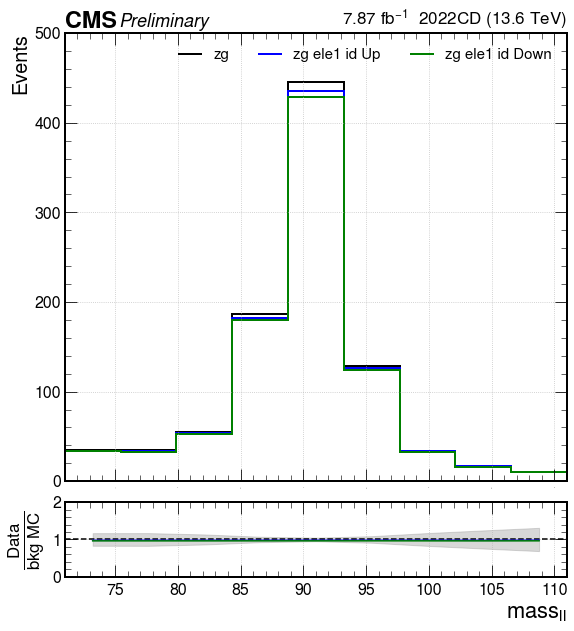

In [64]:
#tesing plot
arrays={
    # k: event_final_2[k]['mu_mass'] for k in event_final_2
    k: event_final_2[k]['ele_mass'] for k in event_final_2
#    k: event_final_2[k]['photon_pt'][:,0] for k in event_final_2 
    # k: event_final_2[k]['photon_pt'] for k in event_final_2 
}
# data_mc_compare_plot(arrays, weight=weight, plot_name='pt_gamma', x_name=r'$P_T \gamma$', x_max=450, x_min=100,y_min=0,y_max=100, bins=7, year='2022CD', density=True,overflow=True)
data_mc_compare_plot(arrays, weight=weight, plot_name='muon_mass', x_name=r'$mass_{ll}$', x_max=111, x_min=71, y_min=0,y_max=500,bins=9, year='2022CD', density=True,overflow=True)#x_max=450, x_min=100,

### 保存root文件

In [65]:

import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [0,50,100, 150, 200, 250, 300, 350, 400, 450]
bins = [71, 76, 81,86,91,96,101,106,111]
# bins = [0,450]

# 创建ROOT文件
with uproot.update("datacard_ele.root") as f:
    
    zg_up_combined_data = []  # 存放所有zg*up样本的数据
    zg_up_combined_weights = []  # 存放所有zg*up样本的权重

    zg_down_combined_data = []  # 存放所有zg*down样本的数据
    zg_down_combined_weights = []  # 存放所有zg*down样本的权重

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():

        # 对于zg*up样本，将它们的数据和权重存储在列表中以便后续合并
        if key.startswith("zg") and "_up" in key:
            zg_up_combined_data.extend(values['ele_mass'])
            # zg_up_combined_data.extend(values['mu_mass'])
            zg_up_combined_weights.extend(weight[key])

        # 对于zg*down样本，将它们的数据和权重存储在列表中以便后续合并
        elif key.startswith("zg") and "_down" in key:
            zg_down_combined_data.extend(values['ele_mass'])
            # zg_down_combined_data.extend(values['mu_mass'])
            zg_down_combined_weights.extend(weight[key])

    # 将所有大于等于450的数据点都设置为450
    # zg_up_combined_data = np.where(np.array(zg_up_combined_data) >= 450, 449.9, np.array(zg_up_combined_data))
    # zg_down_combined_data = np.where(np.array(zg_down_combined_data) >= 450, 449.9, np.array(zg_down_combined_data))
    
    # 对zg*up样本进行合并并保存
    zg_up_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_up_hist.fill(zg_up_combined_data, weight=np.array(zg_up_combined_weights))
    f["zg_ele1_id_Up"] = zg_up_hist.to_numpy()
    
    # 对zg*down样本进行合并并保存
    zg_down_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_down_hist.fill(zg_down_combined_data, weight=np.array(zg_down_combined_weights))
    f["zg_ele1_id_Down"] = zg_down_hist.to_numpy()


## ZG ele2

In [66]:
event_final_2 = {
    'zg0_22':event_final['zg0_22'],
    'zg0_22_ele2_id_up':event_final['zg0_22'],
    'zg0_22_ele2_id_down':event_final['zg0_22'],
    'zg1_22':event_final['zg1_22'],
    'zg1_22_ele2_id_up':event_final['zg1_22'],
    'zg1_22_ele2_id_down':event_final['zg1_22'],
    'zg2_22':event_final['zg2_22'],
    'zg2_22_ele2_id_up':event_final['zg2_22'],
    'zg2_22_ele2_id_down':event_final['zg2_22'],
    'zg3_22':event_final['zg3_22'],
    'zg3_22_ele2_id_up':event_final['zg3_22'],
    'zg3_22_ele2_id_down':event_final['zg3_22'],
}

In [35]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, y_min=0,y_max=250,density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)

        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        
        if 'zg' in k and ('down' not in k) and ('up' not in k):
            if 'zg' not in stacked['h']:
                stacked['h']['zg'] = h
            else:
                stacked['h']['zg'] += h
            continue
        if 'zg' in k and 'up' in k:
            if 'zg_up' not in stacked['h']:
                stacked['h']['zg_up'] = h
            else:
                stacked['h']['zg_up'] += h
            continue
        if 'zg' in k and 'down' in k:
            if 'zg_down' not in stacked['h']:
                stacked['h']['zg_down'] = h
            else:
                stacked['h']['zg_down'] += h
            continue


#######
    # 创建颜色映射
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow']#muted green
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if ('zg' in key) and ('up' not in key)  and ('down' not in key) :
            color_dict['zg'] = 'black'
        elif ('zg' in key) and ('up' in key):
            color_dict['zg_up'] = 'blue'
        elif ('zg' in key) and ('down' in key) :
            color_dict['zg_down'] = 'green'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    label_dict = {
        "zg": "zg",
        "zg_up": "zg ele2 id Up",
        "zg_down": "zg ele2 id Down"
        }
    
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=[label_dict[key] for key in stacked['h'].keys()], histtype='step', linestyle='-', density=density, stack=False, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        # hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='step', linestyle='-', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    # if not density:
    #     ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    ax.set_ylim(y_min, y_max)    

    if 'zg' in stacked['h'] and 'zg_up' in stacked['h'] and 'zg_down' in stacked['h']:
        x_values = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        zg_values = stacked['h']['zg']
        zg_up_values = stacked['h']['zg_up'] / zg_values
        zg_down_values = stacked['h']['zg_down'] / zg_values
        ax1.plot(x_values, zg_up_values, label='zg_up/zg', color='blue')
        ax1.plot(x_values, zg_down_values, label='zg_down/zg', color='green')

        # 计算zg的统计误差
        zg_errors = np.sqrt(zg_values) / zg_values
        ax1.fill_between(x_values, 1 - zg_errors, 1 + zg_errors, color='gray', alpha=0.3, label='zg stat. uncertainty')

    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    


    plt.xticks(size=16)
    plt.yticks(size=16)



    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.show()

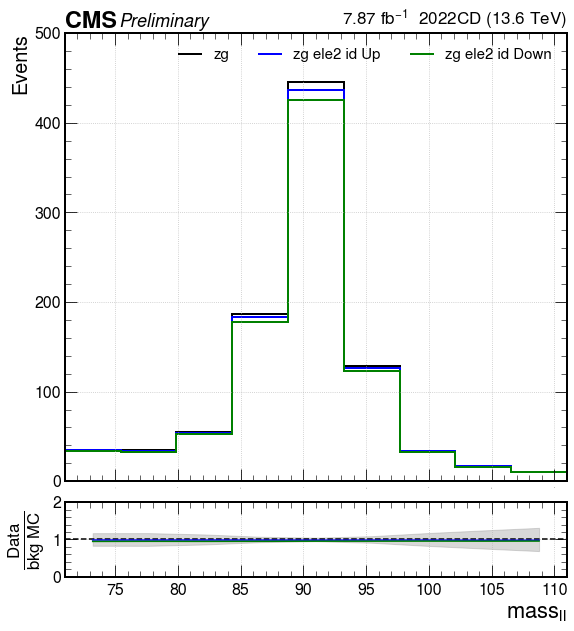

In [36]:
#tesing plot
arrays={
    # k: event_final_2[k]['mu_mass'] for k in event_final_2
    k: event_final_2[k]['ele_mass'] for k in event_final_2
#    k: event_final_2[k]['photon_pt'][:,0] for k in event_final_2 
    # k: event_final_2[k]['photon_pt'] for k in event_final_2 
}
# data_mc_compare_plot(arrays, weight=weight, plot_name='pt_gamma', x_name=r'$P_T \gamma$', x_max=450, x_min=100,y_min=0,y_max=100, bins=7, year='2022CD', density=True,overflow=True)
data_mc_compare_plot(arrays, weight=weight, plot_name='muon_mass', x_name=r'$mass_{ll}$', x_max=111, x_min=71, y_min=0,y_max=500,bins=9, year='2022CD', density=True,overflow=True)#x_max=450, x_min=100,

## 保存root

In [67]:

import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [0,50,100, 150, 200, 250, 300, 350, 400, 450]
bins = [71, 76, 81,86,91,96,101,106,111]
# bins = [0,450]

# 创建ROOT文件
with uproot.update("datacard_ele.root") as f:
    
    zg_up_combined_data = []  # 存放所有zg*up样本的数据
    zg_up_combined_weights = []  # 存放所有zg*up样本的权重

    zg_down_combined_data = []  # 存放所有zg*down样本的数据
    zg_down_combined_weights = []  # 存放所有zg*down样本的权重

    # 对于event_final_2中的每个key
    for key, values in event_final_2.items():

        # 对于zg*up样本，将它们的数据和权重存储在列表中以便后续合并
        if key.startswith("zg") and "_up" in key:
            zg_up_combined_data.extend(values['ele_mass'])
            # zg_up_combined_data.extend(values['mu_mass'])
            zg_up_combined_weights.extend(weight[key])

        # 对于zg*down样本，将它们的数据和权重存储在列表中以便后续合并
        elif key.startswith("zg") and "_down" in key:
            zg_down_combined_data.extend(values['ele_mass'])
            # zg_down_combined_data.extend(values['mu_mass'])
            zg_down_combined_weights.extend(weight[key])

    # 将所有大于等于450的数据点都设置为450
    # zg_up_combined_data = np.where(np.array(zg_up_combined_data) >= 450, 449.9, np.array(zg_up_combined_data))
    # zg_down_combined_data = np.where(np.array(zg_down_combined_data) >= 450, 449.9, np.array(zg_down_combined_data))
    
    # 对zg*up样本进行合并并保存
    zg_up_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_up_hist.fill(zg_up_combined_data, weight=np.array(zg_up_combined_weights))
    f["zg_ele2_id_Up"] = zg_up_hist.to_numpy()
    
    # 对zg*down样本进行合并并保存
    zg_down_hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
    zg_down_hist.fill(zg_down_combined_data, weight=np.array(zg_down_combined_weights))
    f["zg_ele2_id_Down"] = zg_down_hist.to_numpy()


## TT

In [68]:
event_final_2 = {
    'tt_22':event_final['tt_22'],
    'tt_22_ele1_id_up':event_final['tt_22'],
    'tt_22_ele1_id_down':event_final['tt_22'],
}


In [54]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, y_min=0,y_max=10,density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)

        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        
        if 'tt' in k and ('down' not in k) and ('up' not in k):
            if 'tt' not in stacked['h']:
                stacked['h']['tt'] = h
            else:
                stacked['h']['tt'] += h
            continue
        if 'tt' in k and 'up' in k:
            if 'tt_up' not in stacked['h']:
                stacked['h']['tt_up'] = h
            else:
                stacked['h']['tt_up'] += h
            continue
        if 'tt' in k and 'down' in k:
            if 'tt_down' not in stacked['h']:
                stacked['h']['tt_down'] = h
            else:
                stacked['h']['tt_down'] += h
            continue


#######
    # 创建颜色映射
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow']#muted green
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if ('tt' in key) and ('up' not in key)  and ('down' not in key) :
            color_dict['tt'] = 'black'
        elif ('tt' in key) and ('up' in key):
            color_dict['tt_up'] = 'blue'
        elif ('tt' in key) and ('down' in key) :
            color_dict['tt_down'] = 'green'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    label_dict = {
        "tt": "ttbar",
        "tt_up": "ttbar ele1 id Up",
        "tt_down": "ttbar ele1 id Down"
        }
    
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=[label_dict[key] for key in stacked['h'].keys()], histtype='step', linestyle='-', density=density, stack=False, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        # hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='step', linestyle='-', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    # if not density:
    #     ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    ax.set_ylim(y_min, y_max)    

    if 'tt' in stacked['h'] and 'tt_up' in stacked['h'] and 'tt_down' in stacked['h']:
        x_values = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        tt_values = stacked['h']['tt']
        tt_up_values = stacked['h']['tt_up'] / tt_values
        tt_down_values = stacked['h']['tt_down'] / tt_values
        ax1.plot(x_values, tt_up_values, label='tt_up/tt', color='blue')
        ax1.plot(x_values, tt_down_values, label='tt_down/tt', color='green')

        # 计算tt的统计误差
        tt_errors = np.sqrt(tt_values) / tt_values
        ax1.fill_between(x_values, 1 - tt_errors, 1 + tt_errors, color='gray', alpha=0.3, label='tt stat. uncertainty')

    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    


    plt.xticks(size=16)
    plt.yticks(size=16)



    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.show()

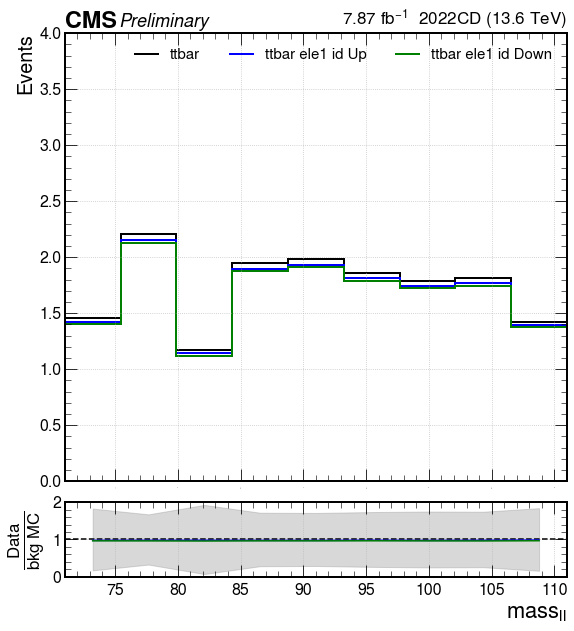

In [55]:
#tesing plot
arrays={
   # k: event_final_2[k]['photon_pt'] for k in event_final_2
   k: event_final_2[k]['ele_mass'] for k in event_final_2
   # k: event_final_2[k]['mu_mass'] for k in event_final_2
}
# data_mc_compare_plot(arrays, weight=weight, plot_name='pt_gamma', x_name=r'$P_T \gamma$', x_max=111, x_min=71, bins=8, year='2022FG', density=True,overflow=True)
# data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$Pt (\gamma)$', x_max=450, x_min=100, y_min=0,y_max=1.5,bins=7, year='2022CD', density=True,overflow=True)
data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$mass_{ll}$', x_max=111, x_min=71, y_min=0,y_max=4,bins=9, year='2022CD', density=True,overflow=True)#x_max=450, x_min=100,

### 保存root

In [69]:
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [0,50,100, 150, 200, 250, 300, 350, 400, 450]
bins = [71, 76, 81,86,91,96,101,106,111]

# 创建ROOT文件
with uproot.update("datacard_ele.root") as f:
    for key, values in event_final_2.items():
        if key == 'tt':
            continue
        # 将所有大于等于450的数据点都设置为450
        data_to_fill = np.where(values['ele_mass'] >= 111, 110.9, values['ele_mass'])
        # data_to_fill = np.where(values['mu_mass'] >= 111, 110.9, values['mu_mass'])
        # data_to_fill = np.where(values['photon_pt'][:,0] >= 450, 449.9, values['photon_pt'][:,0])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill, weight=weight[key])
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        if 'up' in key:
             f["tt_ele1_id_Up"] = hist.to_numpy()
        if 'down' in key:
            f["tt_ele1_id_Down"] = hist.to_numpy()
        


## tt ele2

In [70]:
event_final_2 = {
    'tt_22':event_final['tt_22'],
    'tt_22_ele2_id_up':event_final['tt_22'],
    'tt_22_ele2_id_down':event_final['tt_22'],
}


In [58]:
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter
import seaborn as sns


LUMI_UNCERTAINTY = 0.024

hep.style.use("CMS")

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='run3', bins=40, x_min=0, x_max=2000, y_min=0,y_max=10,density=False, overflow=True, underflow=False, fraction_log=False):
    density = False
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
#    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    rlabel_content = f'{LUMI[year]} $fb^{{-1}}$  {year} (13.6 TeV)'
    hep.cms.label(data=True, year=year, ax=ax, fontsize=18, llabel='Preliminary', rlabel=rlabel_content)
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
########
#    bkg_total_err = error_bar(np.sqrt(bkg_total_err), bkg_total_err, type='mc')
    bkg_total_err = np.zeros(bins)



    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
#        if k!='data' and k!= 'nonprompt' and weight is not None:
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)

        
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)

        
        if 'tt' in k and ('down' not in k) and ('up' not in k):
            if 'tt' not in stacked['h']:
                stacked['h']['tt'] = h
            else:
                stacked['h']['tt'] += h
            continue
        if 'tt' in k and 'up' in k:
            if 'tt_up' not in stacked['h']:
                stacked['h']['tt_up'] = h
            else:
                stacked['h']['tt_up'] += h
            continue
        if 'tt' in k and 'down' in k:
            if 'tt_down' not in stacked['h']:
                stacked['h']['tt_down'] = h
            else:
                stacked['h']['tt_down'] += h
            continue


#######
    # 创建颜色映射
    colors = ['dark','sea blue','neon blue','fern','light green','orange yellow']#muted green
    color_dict = {}
    color_idx = 0
    for key in arrays.keys():
        if ('tt' in key) and ('up' not in key)  and ('down' not in key) :
            color_dict['tt'] = 'black'
        elif ('tt' in key) and ('up' in key):
            color_dict['tt_up'] = 'blue'
        elif ('tt' in key) and ('down' in key) :
            color_dict['tt_down'] = 'green'
        else:
            color_dict[key] = sns.xkcd_rgb[colors[color_idx]]
            color_idx += 1

    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    label_dict = {
        "tt": "ttbar",
        "tt_up": "ttbar ele2 id Up",
        "tt_down": "ttbar ele2 id Down"
        }
    
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=[label_dict[key] for key in stacked['h'].keys()], histtype='step', linestyle='-', density=density, stack=False, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        # hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='step', linestyle='-', density=density, stack=True, linewidth=2, ax=ax, color=[color_dict[key] for key in stacked['h'].keys()])
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))

    
    # if not density:
    #     ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    ax.set_ylim(y_min, y_max)    

    if 'tt' in stacked['h'] and 'tt_up' in stacked['h'] and 'tt_down' in stacked['h']:
        x_values = (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:]) / 2
        tt_values = stacked['h']['tt']
        tt_up_values = stacked['h']['tt_up'] / tt_values
        tt_down_values = stacked['h']['tt_down'] / tt_values
        ax1.plot(x_values, tt_up_values, label='tt_up/tt', color='blue')
        ax1.plot(x_values, tt_down_values, label='tt_down/tt', color='green')

        # 计算tt的统计误差
        tt_errors = np.sqrt(tt_values) / tt_values
        ax1.fill_between(x_values, 1 - tt_errors, 1 + tt_errors, color='gray', alpha=0.3, label='tt stat. uncertainty')

    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    


    plt.xticks(size=16)
    plt.yticks(size=16)



    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.show()

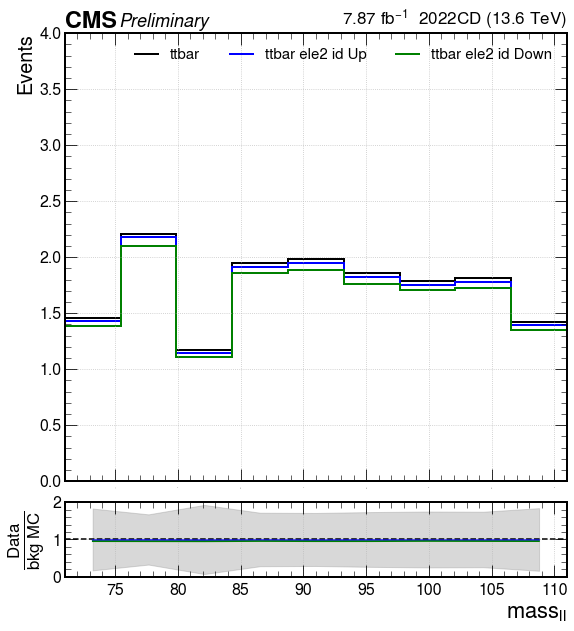

In [59]:
#tesing plot
arrays={
   # k: event_final_2[k]['photon_pt'] for k in event_final_2
   k: event_final_2[k]['ele_mass'] for k in event_final_2
   # k: event_final_2[k]['mu_mass'] for k in event_final_2
}
# data_mc_compare_plot(arrays, weight=weight, plot_name='pt_gamma', x_name=r'$P_T \gamma$', x_max=111, x_min=71, bins=8, year='2022FG', density=True,overflow=True)
# data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$Pt (\gamma)$', x_max=450, x_min=100, y_min=0,y_max=1.5,bins=7, year='2022CD', density=True,overflow=True)
data_mc_compare_plot(arrays, weight=weight, plot_name='photon_pt', x_name=r'$mass_{ll}$', x_max=111, x_min=71, y_min=0,y_max=4,bins=9, year='2022CD', density=True,overflow=True)#x_max=450, x_min=100,

## save root

In [71]:
import boost_histogram as bh
import uproot
import numpy as np

# 设置bins，不包括underflow和overflow
# bins = [0,50,100, 150, 200, 250, 300, 350, 400, 450]
bins = [71, 76, 81,86,91,96,101,106,111]

# 创建ROOT文件
with uproot.update("datacard_ele.root") as f:
    for key, values in event_final_2.items():
        if key == 'tt':
            continue
        # 将所有大于等于450的数据点都设置为450
        data_to_fill = np.where(values['ele_mass'] >= 111, 110.9, values['ele_mass'])
        # data_to_fill = np.where(values['mu_mass'] >= 111, 110.9, values['mu_mass'])
        # data_to_fill = np.where(values['photon_pt'][:,0] >= 450, 449.9, values['photon_pt'][:,0])
        
        # 创建boost_histogram直方图，并明确指定使用underflow和overflow bins
        hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1], underflow=True, overflow=True))
        
        # 使用photon_pt和对应的权重填充直方图
        hist.fill(data_to_fill, weight=weight[key])
        
        # 将boost_histogram直方图转换为TH1并保存到ROOT文件中
        if 'up' in key:
             f["tt_ele2_id_Up"] = hist.to_numpy()
        if 'down' in key:
            f["tt_ele2_id_Down"] = hist.to_numpy()
        
